# Sheet 3 - Exercise 2

## Instructions To Run This Notebook

### On your local machine (Assuming MacOS or Linux based distribution)

1. Create a folder: `mkdir sheet3`
2. Go to the folder `cd sheet3`
3. Install all the necessary dependencies (we assume you already have python and pip) by running the following command:
    `pip install pyspark pandas matplotlib numpy scikit-learn`
4. Download the files **After_Pre_Processing.xlsx** and **Before_Pre_Processing.xlsx** from moodle if you don't have them
5. Put the **After_Pre_Processing.xlsx** and **Before_Pre_Processing.xlsx** in the folder **sheet3** you have just created
6. Put this notebook **sheet3_exercise2.ipynb** in the same folder **sheet3**
7. Make sure the image **metrics.png** is also in the same folder
8. Now you can run this notebook on *Jupyter* or *VSCode* by clicking "Run All"

### On HPC 

To run this notebook on HPC you will first need to setup Jupyter on HPC by following these steps:

1. Log into your HPC instance by using the command: `ssh -p 8022 <your-login>@access-iris.uni.lu` (replace your-login with your HPC login)
2. Once logged in, initialize a session using `si`
3. Create a directory inside HPC: `mkdir sheet3`
4. Go to the directory: `cd sheet3`
5. Load python: `module load lang/Python`
6. Create a Python environment for this activity: `python -m venv jupyter_env`
7. Activate the environment: `source jupyter_env/bin/activate`
8. Install/Upgrade pip: `python -m pip install --upgrade pip`
9. Install Jupyter: `python -m pip install jupyter ipykernel`
10. Install all the required dependencies: `pip install pyspark pandas matplotlib numpy scikit-learn`
11. Register our environment to the Jupyter kernel: `python -m ipykernel install --sys-prefix --name jupyter_env`
12. Run the following command to launch a jupyter server on HPC: `jupyter notebook --no-browser --port=8888 --NotebookApp.token='' --NotebookApp.password='' -NotebookApp.disable_check_xsrf=True --ip=0.0.0.0`


Now go on your local machine, open a new terminal tab and do the following:
1. Copy files from local to HPC, on your local machine within the directory where you have the .ipynb and .xlsx files stored run the following commands:
`scp -P 8022 sheet3_exercise2.ipynb <your-login>@access-iris.uni.lu:~/sheet3`
`scp -P 8022 After_Pre_Processing.xlsx <your-login>@access-iris.uni.lu:~/sheet3`
`scp -P 8022 Before_Pre_Processing.xlsx <your-login>@access-iris.uni.lu:~/sheet3`
2. Launch the jupyter notebook on localhost by running: `ssh -p 8022 -NL 8888:iris-XXX:8888 <your-login>@access-iris.uni.lu` and replace XXX by the number of the iris cluster provided to you on HPC for example I have on HPC *(jupyter_env) 0 [omahfoud@iris-055 sheet3](3487277 1N/T/1CN)$* so I would replace XXX by *055*
3. On your machine open your favorite browser and go to `localhost:8888` or `http://127.0.0.1:8888/` this should open your Jupyter interface
4. Click on **sheet3_exercise2.ipynb** then click on **Run All*

## Important Note for the Instructor !!

Here since it was not specified explicitly, and as asked to Professor Di Tollo in class, I am only using one file which is *After_Pre_Processing.xlsx* , unless explicitly asked otherwise we will be using that file to do our exercises. <br>
Please not here that since the variable `S1Q06_P1nor` is a continuous variable I have considered that the problem related to it is a regression problem. <br>
On the other hand, since the variable `S1Q061nor`has encoded values that can be considered categories (0, 0.5, 1) I have considered its prediction a classification problem.

## Decision Tree Regression for Continuous Variable

### Module Imports and Data Acquisition

In [2]:
!pip install pyspark pandas matplotlib numpy scikit-learn

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import warnings
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder.appName("sheet3_exercise2").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

warnings.filterwarnings('ignore')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/27 21:12:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/27 21:12:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
raw_data = pd.read_excel("After_Pre_Processing.xlsx")
spark_df = spark.createDataFrame(raw_data)
spark_df.show()

+-------+--------+-----+---------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------+------+-------------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+-------

In [5]:
# remove the USER column
spark_df = spark_df.drop('USER')

### Define target variables

In [6]:
target = 'S1Q06_P1nor'

### Handling missing values

In [7]:
def fill_missing_values(df):
    for column in df.columns:
        if df.schema[column].dataType == "DoubleType":
            mean_value = df.select(col(column)).na.drop().groupBy().avg(column).first()[0]
            df = df.fillna(mean_value, subset=[column])
        else:
            mode_value = df.groupBy(column).count().orderBy('count', ascending=False).first()[0]
            df = df.fillna(mode_value, subset=[column])
    return df

spark_df = fill_missing_values(spark_df)

### Ensure all string columns are properly handled

In [8]:
for column in spark_df.columns:
    if spark_df.schema[column].dataType == "StringType":
        spark_df = spark_df.withColumn(column, when(col(column).isNull(), "").otherwise(col(column)))

### Encode categorical variables using StringIndexer

In [9]:
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(spark_df)
            for column in spark_df.columns if spark_df.schema[column].dataType == "StringType"]

### Assemble features into a single vector

In [10]:
assembler = VectorAssembler(inputCols=[col + "_indexed" if col + "_indexed" in spark_df.columns else col for col in spark_df.columns if col != target],
                            outputCol="features")

### Create a pipeline for preprocessing

In [11]:
pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(spark_df)
preprocessed_df = pipeline_model.transform(spark_df)

### Show the preprocessed data

In [12]:
preprocessed_df.show()

+--------+-----+---------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------+------+-------------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+---------------

### Function to train and evaluate a decision tree model

In [13]:
def train_and_evaluate(spark_df, target):
    (train_data, test_data) = spark_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeRegressor(labelCol=target, featuresCol="features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    metrics = ['rmse', 'mse', 'mae', 'r2']
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")
    results = {metric: evaluator.setMetricName(metric).evaluate(predictions) for metric in metrics}
    print(f"Evaluation metrics for {target}:")
    for metric, value in results.items():
        print(f"{metric.upper()}: {value}")

    return model

### Train and evaluate models for each target variablev

In [14]:
model = train_and_evaluate(preprocessed_df, target)

Evaluation metrics for S1Q06_P1nor:
RMSE: 0.06841368202182321
MSE: 0.004680431887783137
MAE: 0.02882319874133314
R2: 0.48590555566361615


### Function to plot feature importance

In [15]:
def plot_feature_importance(model, feature_names, target):
    importances = model.featureImportances
    indices = np.argsort(importances)[::-1].tolist()  # Convert indices to a list of integers

    filtered_indices = [idx for idx in indices if importances[idx] > 0.01]
    filtered_importances = [importances[idx] for idx in filtered_indices]
    filtered_feature_names = [feature_names[idx] for idx in filtered_indices]

    plt.figure(figsize=(10, 20)) 
    plt.title(f"Feature importances for {target}")
    plt.barh(range(len(filtered_importances)), filtered_importances, align="center")
    plt.yticks(range(len(filtered_importances)), filtered_feature_names, rotation=0)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

### Extract feature names

In [16]:
feature_names = assembler.getInputCols()

### Plot feature importances for each model

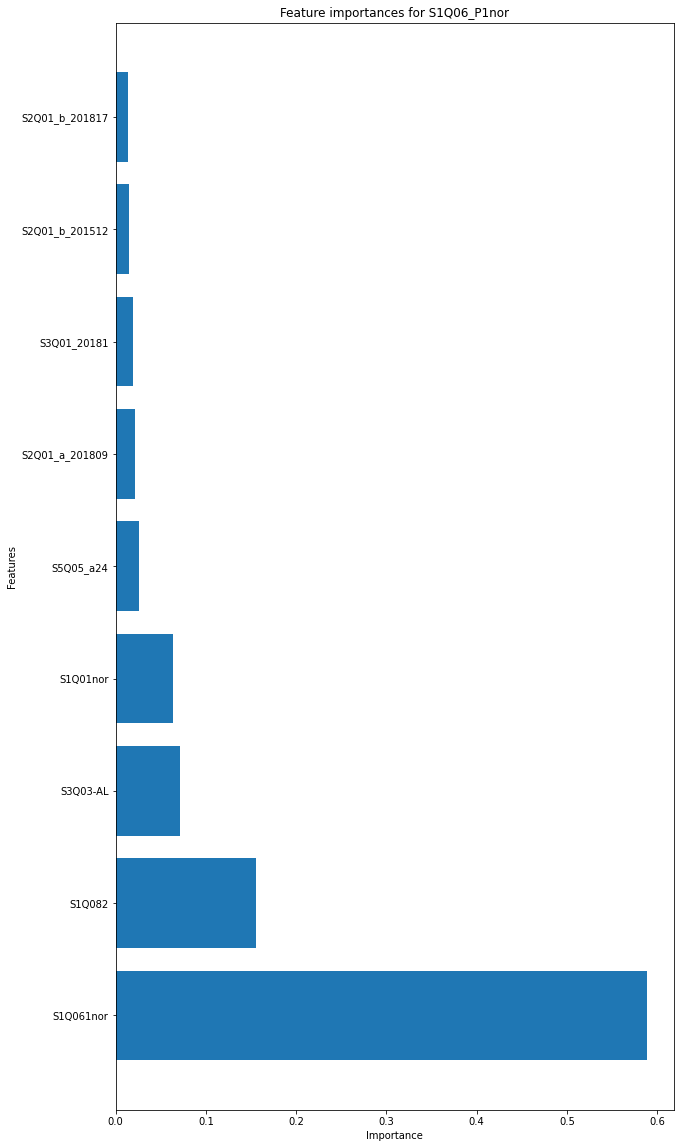

In [17]:
plot_feature_importance(model, feature_names, target)

### Select Important Features

In [18]:
def select_important_features(model, feature_names, threshold=0.01):
    importances = model.featureImportances
    selected_features = [feature_names[idx] for idx in range(len(importances)) if importances[idx] > threshold]
    return selected_features

In [19]:
selected_features = select_important_features(model, feature_names)
print(f"Selected features: {selected_features}")

Selected features: ['S1Q01nor', 'S1Q061nor', 'S1Q082', 'S2Q01_a_201809', 'S2Q01_b_201512', 'S2Q01_b_201817', 'S3Q01_20181', 'S3Q03-AL', 'S5Q05_a24']


### Retrain the model on selected features

In [20]:
def retrain_with_selected_features(spark_df, selected_features, target):
    assembler = VectorAssembler(inputCols=selected_features, outputCol="selected_features")

    pipeline = Pipeline(stages=indexers + [assembler])
    pipeline_model = pipeline.fit(spark_df)
    preprocessed_df = pipeline_model.transform(spark_df)

    (train_data, test_data) = preprocessed_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeRegressor(labelCol=target, featuresCol="selected_features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    metrics = ['rmse', 'mse', 'mae', 'r2']
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")
    results = {metric: evaluator.setMetricName(metric).evaluate(predictions) for metric in metrics}
    print(f"Evaluation metrics for {target} with selected features:")
    for metric, value in results.items():
        print(f"{metric.upper()}: {value}")

    return model

In [21]:
selected_model = retrain_with_selected_features(spark_df, selected_features, target)

Evaluation metrics for S1Q06_P1nor with selected features:
RMSE: 0.07025767758800665
MSE: 0.004936141260060292
MAE: 0.02727346945428982
R2: 0.4578186673583803


We notice that reducing the number of features and selecting only the most important ones has increased our error, therefore in our case fr this regression it was not useful

## Decision Tree Classifier for Categorical Variable

### Imports

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Create the dataframe from our data and follow the same steps as above 

In [23]:
spark_df = spark.createDataFrame(raw_data)

In [24]:
spark_df = spark_df.drop('USER')

In [25]:
target = 'S1Q061nor'

In [26]:
spark_df = spark_df.withColumn(target, col(target) * 2)

In [27]:
spark_df = fill_missing_values(spark_df)

In [28]:
for column in spark_df.columns:
    if spark_df.schema[column].dataType == "StringType":
        spark_df = spark_df.withColumn(column, when(col(column).isNull(), "").otherwise(col(column)))

### Define indexers and assembler

In [29]:
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(spark_df)
            for column in spark_df.columns if spark_df.schema[column].dataType == "StringType"]

In [30]:
assembler = VectorAssembler(inputCols=[col + "_indexed" if col + "_indexed" in spark_df.columns else col for col in spark_df.columns if col != target],
                            outputCol="features")

### Create pre-processing pipeline

In [31]:
pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(spark_df)
preprocessed_df = pipeline_model.transform(spark_df)

In [32]:
preprocessed_df.show()

+--------+-----+---------+-------------------+---------+---------+---------+---------+--------------------+--------------------+------+------+-------------------+--------------+--------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+---------------

### Train and evaluate a decision tree classifier model

In [33]:
def train_and_evaluate(spark_df, target):
    (train_data, test_data) = spark_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeClassifier(labelCol=target, featuresCol="features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
    metrics = {
        "accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
        "precision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        "recall": evaluator.setMetricName("weightedRecall").evaluate(predictions),
        "f1": evaluator.setMetricName("f1").evaluate(predictions)
    }
    print(f"Evaluation metrics for {target}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {round(value, 4)}")

    return model

In [34]:
model = train_and_evaluate(preprocessed_df, target)

Evaluation metrics for S1Q061nor:
Accuracy: 0.9884
Precision: 0.9886
Recall: 0.9884
F1: 0.9882


### Identify features' importance

In [35]:
feature_names = assembler.getInputCols()

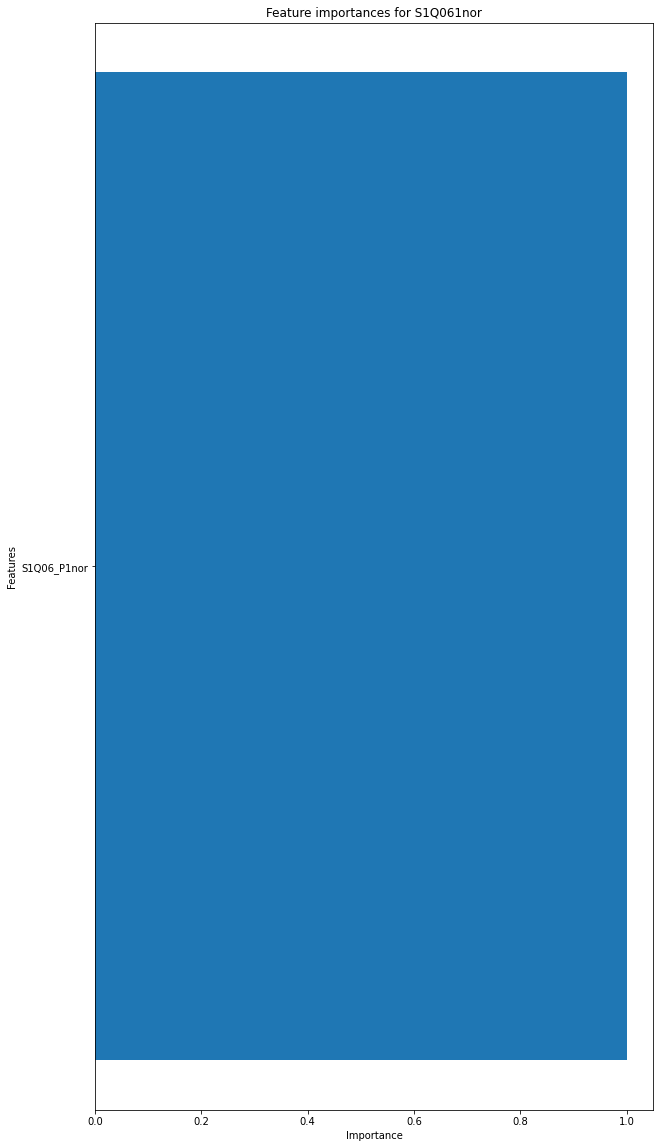

In [36]:
plot_feature_importance(model, feature_names, target)

In [37]:
selected_features = select_important_features(model, feature_names)
print(f"Selected features: {selected_features}")

Selected features: ['S1Q06_P1nor']


### Retrain the model only with selected features

In [38]:
def retrain_with_selected_features(spark_df, selected_features, target):
    assembler = VectorAssembler(inputCols=selected_features, outputCol="selected_features")

    pipeline = Pipeline(stages=indexers + [assembler])
    pipeline_model = pipeline.fit(spark_df)
    preprocessed_df = pipeline_model.transform(spark_df)

    (train_data, test_data) = preprocessed_df.randomSplit([0.7, 0.3], seed=42)

    dt = DecisionTreeClassifier(labelCol=target, featuresCol="selected_features")

    model = dt.fit(train_data)

    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction")
    metrics = {
        "accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
        "precision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
        "recall": evaluator.setMetricName("weightedRecall").evaluate(predictions),
        "f1": evaluator.setMetricName("f1").evaluate(predictions)
    }
    print(f"Evaluation metrics for {target} with selected features:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {round(value,4)}")

    return model

In [39]:
selected_model = retrain_with_selected_features(spark_df, selected_features, target)

Evaluation metrics for S1Q061nor with selected features:
Accuracy: 0.9884
Precision: 0.9886
Recall: 0.9884
F1: 0.9882


Once again training only with the selected features had no impact on the model's performance metrics